In [1]:
import jax
import jax.nn as jnn
import jax.numpy as jnp
import numpy as np

import equinox as eqx
import diffrax
import optax
from functools import partial

from tqdm import tqdm

In [2]:
import os
os.chdir("..")
from policy.policy_training import DPCTrainer
from exciting_environments.pmsm.pmsm_env import PMSM, step_eps
import jax_dataclasses as jdc
from models.models import MLP
#from policy.networks import MLP#,MLP2
import matplotlib.pyplot as plt

2025-01-16 12:44:46.605349: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
gpus = jax.devices()
jax.config.update("jax_default_device", gpus[0])
jax.config.update("jax_enable_x64", True)

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
def valid_points(Z,D,Q):
    def cond(point):
        return (point[0]**2+point[1]**2-250**2 <= 0).astype(int)
    z_flat=Z.flatten()
    points=jnp.array([D.flatten(),Q.flatten()]).T
    val_points=jax.vmap(cond,in_axes=0)(points)
    z_flat_val=z_flat*val_points
    return z_flat_val.reshape(D.shape)

def eval_psi(expert_model):
    fig = plt.figure(figsize=(12,8))
    xx = np.linspace(-250, 0, 26)
    yy = np.linspace(-250, 250, 51)
    D, Q = np.meshgrid(xx, yy, indexing='ij')
    learned_psi={"Psi_d":expert_model.psi_d_mlp,"Psi_q":expert_model.psi_q_mlp}

    for  i,name in  zip(range(2),["Psi_d","Psi_q"]):
        
        interp=expert_model.motor_env.LUT_interpolators[name]
        Z = interp((D,Q))
        
        Z=Z*1000
        Z=valid_points(Z,D,Q)
        ax = fig.add_subplot(2, 3, 3*i +1, projection='3d')
        norm = plt.Normalize(Z.min(), Z.max())
        colors = cm.viridis(norm(Z))
        rcount, ccount, _ = colors.shape
        surf = ax.plot_surface(D,Q, Z, rcount=rcount, ccount=ccount,
                        facecolors=colors, shade=False)
        surf.set_facecolor((0,0,0,0))
        ax.azim=225
        ax.set_xlabel("i_d in A")
        ax.set_ylabel("i_q in A")
        ax.set_title(name+' in mH - LUT')

        mlp=learned_psi[name]
        z_flatt=jax.vmap(mlp)(jnp.array([D.flatten(),Q.flatten()]).T/expert_model.motor_env.env_properties.physical_constraints.i_d) #
        Z_d=z_flatt.reshape(D.shape)*1000
        
        Z_d=valid_points(Z_d,D,Q)

        ax = fig.add_subplot(2, 3, 3*i +2, projection='3d')
        norm = plt.Normalize(Z_d.min(), Z_d.max())
        colors = cm.viridis(norm(Z_d))
        rcount, ccount, _ = colors.shape
        surf = ax.plot_surface(D, Q, Z_d, rcount=rcount, ccount=ccount,
                        facecolors=colors, shade=False)
        surf.set_facecolor((0,0,0,0))
        ax.azim=225
        ax.set_xlabel("i_d in A")
        ax.set_ylabel("i_q in A")
        ax.set_title(name+' in mH - learned MLP')

        Z_difference=jnp.abs(Z - Z_d) #np.abs
        ax = fig.add_subplot(2, 3, 3*i +3, projection='3d')
        norm = plt.Normalize(Z_difference.min(), Z_difference.max())
        colors = cm.viridis(norm(Z_difference))
        rcount, ccount, _ = colors.shape
        surf = ax.plot_surface(D, Q, Z_difference, rcount=rcount, ccount=ccount,
                        facecolors=colors, shade=False)
        surf.set_facecolor((0,0,0,0))
        ax.azim=225
        ax.set_xlabel("i_d in A")
        ax.set_ylabel("i_q in A")
        ax.set_title('abs. error in mH')
        ax.ticklabel_format(style='plain')

    fig.show()

def eval_L(expert_model):
    fig = plt.figure(figsize=(12,20))
    xx = np.linspace(-250, 0, 26)
    yy = np.linspace(-250, 250, 51)
    D, Q = np.meshgrid(xx, yy, indexing='ij')
    learned_psi={"L_dd":expert_model.L_dd_mlp,"L_dq":expert_model.L_dq_mlp,"L_qd":expert_model.L_qd_mlp,"L_qq":expert_model.L_qq_mlp}

    for  i,name in  zip(range(4),["L_dd","L_dq","L_qd","L_qq"]):
        
        interp=motor_env.LUT_interpolators[name]
        Z = interp((D,Q))
        
        Z=Z*1000
        Z=valid_points(Z,D,Q)
        ax = fig.add_subplot(4, 3, 3*i +1, projection='3d')
        norm = plt.Normalize(Z.min(), Z.max())
        colors = cm.viridis(norm(Z))
        rcount, ccount, _ = colors.shape
        surf = ax.plot_surface(D,Q, Z, rcount=rcount, ccount=ccount,
                        facecolors=colors, shade=False)
        surf.set_facecolor((0,0,0,0))
        ax.azim=225
        ax.set_xlabel("i_d in A")
        ax.set_ylabel("i_q in A")
        ax.set_title(name+' in mH - LUT')

        mlp=learned_psi[name]
        z_flatt=jax.vmap(mlp)(jnp.array([D.flatten(),Q.flatten()]).T/motor_env.env_properties.physical_constraints.i_d)#
        Z_d=z_flatt.reshape(D.shape)*1000
        Z_d=Z_d*1e-3
        
        Z_d=valid_points(Z_d,D,Q)

        ax = fig.add_subplot(4, 3, 3*i +2, projection='3d')
        norm = plt.Normalize(Z_d.min(), Z_d.max())
        colors = cm.viridis(norm(Z_d))
        rcount, ccount, _ = colors.shape
        surf = ax.plot_surface(D, Q, Z_d, rcount=rcount, ccount=ccount,
                        facecolors=colors, shade=False)
        surf.set_facecolor((0,0,0,0))
        ax.azim=225
        ax.set_xlabel("i_d in A")
        ax.set_ylabel("i_q in A")
        ax.set_title(name+' in mH - learned MLP')

        Z_difference=jnp.abs(Z - Z_d) #np.abs
        ax = fig.add_subplot(4, 3, 3*i +3, projection='3d')
        norm = plt.Normalize(Z_difference.min(), Z_difference.max())
        colors = cm.viridis(norm(Z_difference))
        rcount, ccount, _ = colors.shape
        surf = ax.plot_surface(D, Q, Z_difference, rcount=rcount, ccount=ccount,
                        facecolors=colors, shade=False)
        surf.set_facecolor((0,0,0,0))
        ax.azim=225
        ax.set_xlabel("i_d in A")
        ax.set_ylabel("i_q in A")
        ax.set_title('abs. error in mH')
        ax.ticklabel_format(style='plain')

    fig.show()



In [5]:
class Inductances(eqx.Module):
    L_dd_mlp: MLP
    L_dq_mlp: MLP
    L_qd_mlp: MLP
    L_qq_mlp: MLP
    #L_mlp: MLP
    
    def __init__(self,L_layer_sizes,key):
        key , subkey = jax.random.split(key)

        self.L_dd_mlp=MLP(L_layer_sizes,key=subkey,hidden_activation=jax.nn.leaky_relu)#,hidden_activation=jnp.tanh
        key , subkey = jax.random.split(key)

        self.L_dq_mlp=MLP(L_layer_sizes,key=subkey,hidden_activation=jax.nn.leaky_relu)#,hidden_activation=jnp.tanh
        key , subkey = jax.random.split(key)

        self.L_qd_mlp=MLP(L_layer_sizes,key=subkey,hidden_activation=jax.nn.leaky_relu)#,hidden_activation=jnp.tanh
        key , subkey = jax.random.split(key)

        self.L_qq_mlp=MLP(L_layer_sizes,key=subkey,hidden_activation=jax.nn.leaky_relu)#,hidden_activation=jnp.tanh
        # key , subkey = jax.random.split(key)
        # self.L_mlp=MLP(L_layer_sizes,key=subkey,hidden_activation=jnp.tanh)

    def __call__(self, i_dq):
        L_dd=self.L_dd_mlp(i_dq)[0]
        L_dq=self.L_dq_mlp(i_dq)[0]
        L_qd=self.L_qd_mlp(i_dq)[0]
        L_qq=self.L_qq_mlp(i_dq)[0]
        mat=jnp.array([[L_dd,L_dq],[L_qd,L_qq]])*1e-3
        return mat

In [6]:
motor_env = PMSM(
    saturated=True,
    LUT_motor_name="BRUSA",
    batch_size=1,
    control_state=[], 
    static_params = {
            "p": 3,
            "r_s": 15e-3,
            "l_d": 0.37e-3,
            "l_q": 1.2e-3,
            "psi_p": 65.6e-3,
            "deadtime": 0,
    })

In [7]:
def get_gt_L(i_dq):
    i_dq=250*i_dq
    L_dd=motor_env.LUT_interpolators["L_dd"](i_dq)[0]
    L_dq=motor_env.LUT_interpolators["L_dq"](i_dq)[0]
    L_qd=motor_env.LUT_interpolators["L_qd"](i_dq)[0]
    L_qq=motor_env.LUT_interpolators["L_qq"](i_dq)[0]
    mat=jnp.array([[L_dd,L_dq],[L_qd,L_qq]])
    return mat

In [8]:
@eqx.filter_value_and_grad
def grad_loss_L(model, i_dqs):

    L_pred=jax.vmap(model)(i_dqs)
    # create vmap_rollout_traj_node
    L_gt=jax.vmap(get_gt_L)(i_dqs)
    
    return jnp.sum((L_pred-L_gt) ** 2)

In [9]:
@eqx.filter_value_and_grad
def grad_loss_L_inv(model, i_dqs):

    L_inv_pred=jax.vmap(jnp.linalg.inv,in_axes=0)(jax.vmap(model)(i_dqs))
    # create vmap_rollout_traj_node
    L_inv_gt=jax.vmap(jnp.linalg.inv,in_axes=0)(jax.vmap(get_gt_L)(i_dqs))
    
    return jnp.mean((L_inv_pred-L_inv_gt) ** 2)

In [10]:
@eqx.filter_jit
def make_step(model, i_dqs, opt_state, optim,grad_loss):
    loss, grads = grad_loss(model,i_dqs)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

In [11]:
def data_gen_single(rng):
    rng, subkey = jax.random.split(rng)
    obs, _ = motor_env.reset(motor_env.env_properties, subkey) 
    i_dqs_norm=jnp.array([obs[0]*0.5-0.5,obs[1]])
    return i_dqs_norm, rng

In [12]:
@eqx.filter_jit
def data_generation(rng):
    i_dq, key = jax.vmap(data_gen_single)(rng)
    return i_dq, key

In [13]:
def fit(
    model,
    train_steps,
    rng,
    optim,
    init_opt_state,
    grad_loss,
    plot_every,
):
    key = rng
    model_state = model
    opt_state = init_opt_state
    train_losses = []
    val_losses = []

    for i in tqdm(range(train_steps)):

        i_dqs, key = data_generation(key)

        model_state, opt_state, loss = make_step(model_state,i_dqs, opt_state, optim,grad_loss)

        train_losses.append(loss)

        
        #if i is not None and i % plot_every == 0:
        

    return model_state, opt_state, key, train_losses, val_losses

In [25]:
jax_key = jax.random.PRNGKey(4) 
node = Inductances(L_layer_sizes=[2,32,32,1],key=jax_key)
#node_L_inv = Inductances_Inv(L_layer_sizes=[2,32,32,1],key=jax_key)

100%|██████████| 100000/100000 [05:18<00:00, 314.38it/s]


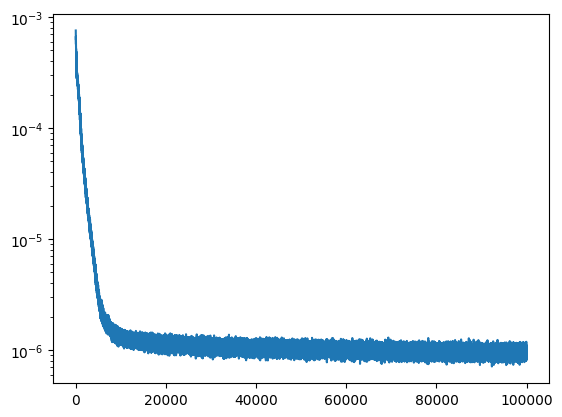

In [26]:
optimizer_node = optax.adam(1e-4)
opt_state = optimizer_node.init(node)
batch_size=1000
keys=jax.vmap(jax.random.PRNGKey)(np.random.randint(0, 2**31, size=(batch_size,)))
fin_node_L,fin_opt_state,fin_key,loss_L,val_loss=fit(node,100000,keys,optimizer_node,opt_state,grad_loss_L,10)
plt.plot(loss_L)
plt.yscale('log')

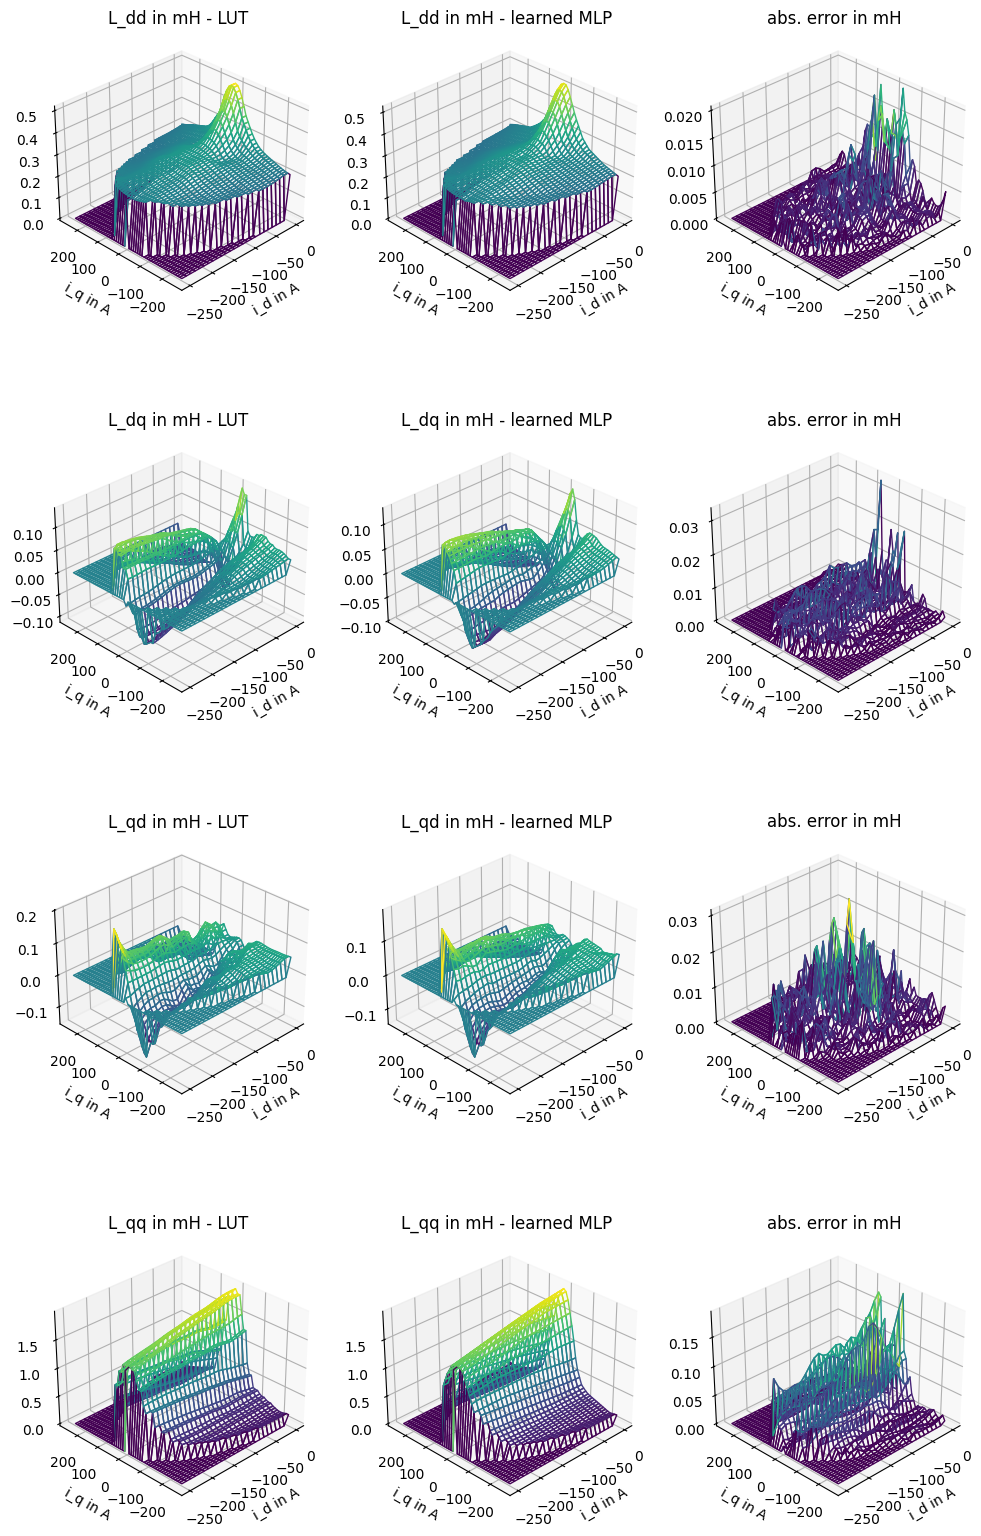

In [27]:
eval_L(fin_node_L)

100%|██████████| 100000/100000 [05:34<00:00, 299.30it/s]


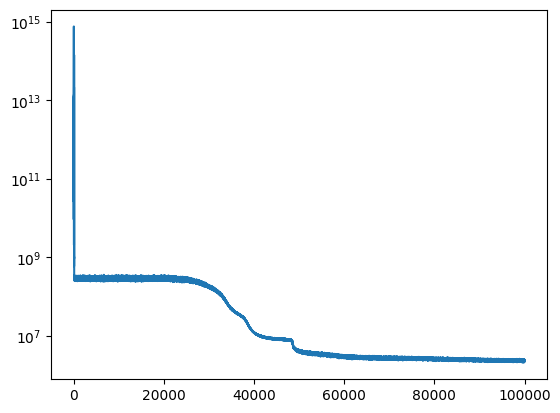

In [17]:
optimizer_node = optax.adam(1e-4)
opt_state = optimizer_node.init(node)
batch_size=1000
keys=jax.vmap(jax.random.PRNGKey)(np.random.randint(0, 2**31, size=(batch_size,)))
fin_node_L_inv,fin_opt_state,fin_key,loss_L_inv,val_loss=fit(node,100000,keys,optimizer_node,opt_state,grad_loss_L_inv,10)
plt.plot(loss_L_inv)
plt.yscale('log')

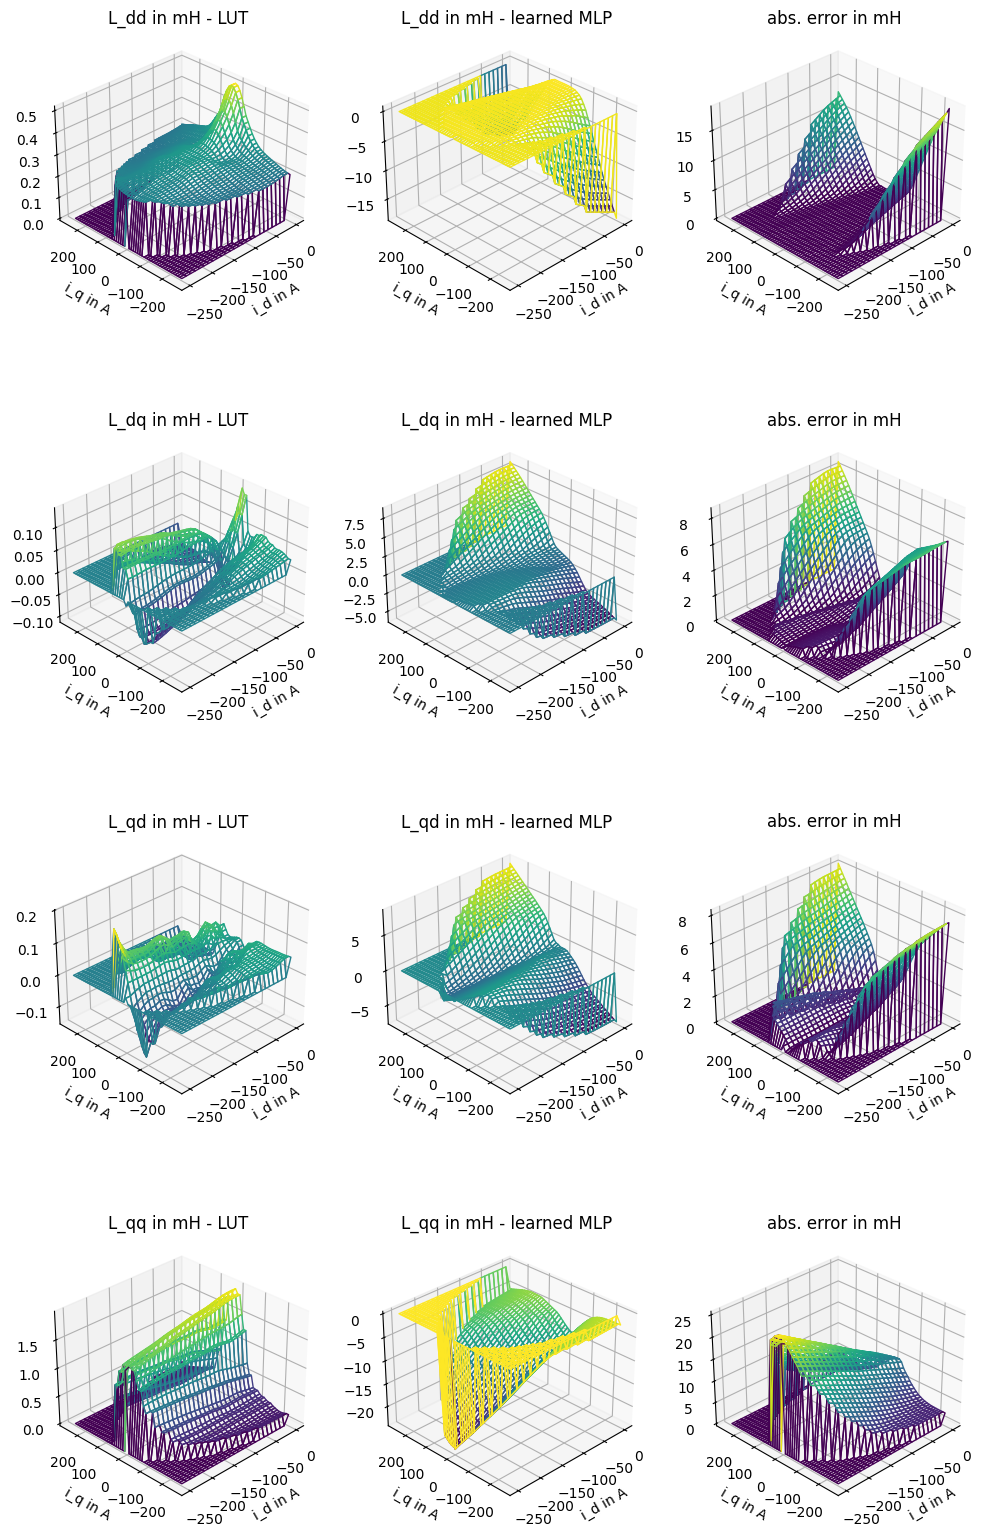

In [30]:
eval_L(fin_node_L_inv)

In [22]:
jax_key = jax.random.PRNGKey(7) 
node2 = Inductances(L_layer_sizes=[2,32,32,1],key=jax_key)

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [05:40<00:00, 293.37it/s]


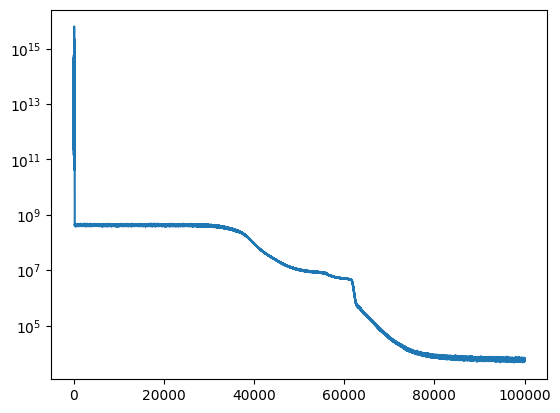

In [23]:
optimizer_node = optax.adam(1e-4)
opt_state = optimizer_node.init(node2)
batch_size=1000
keys=jax.vmap(jax.random.PRNGKey)(np.random.randint(0, 2**31, size=(batch_size,)))
fin_node_L_inv2,fin_opt_state,fin_key,loss_L_inv2,val_loss=fit(node2,100000,keys,optimizer_node,opt_state,grad_loss_L_inv,10)
plt.plot(loss_L_inv2)
plt.yscale('log')

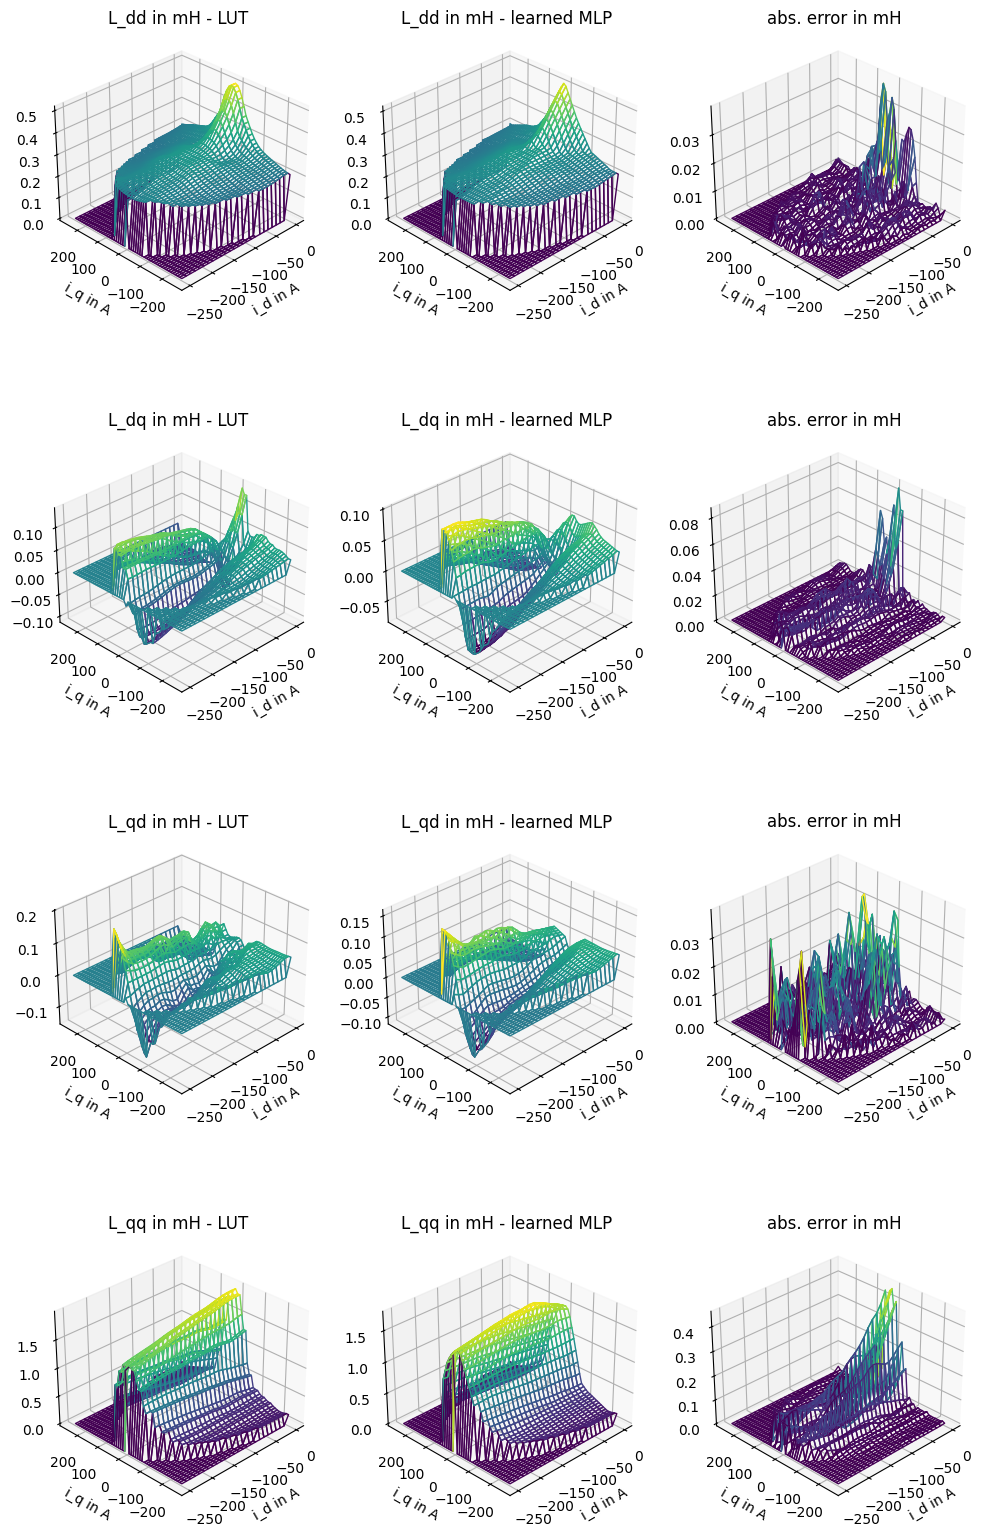

In [24]:
eval_L(fin_node_L_inv2)